# 四阶龙格库塔求解NLSE

函数 ask_dBdz 输入参数: z, B, f, beta2, gamma
    计算相位变化: phase = exp(i * 0.5 * beta2 * z * (2πf)^2)
    计算变换后的值: a = 傅里叶逆变换(傅里叶变换(B * phase))
    返回非线性项: 1i * gamma * 傅里叶逆变换(a * 共轭(a) * a) * exp(-i * 0.5 * beta2 * z * (2πf)^2)

给定光纤二阶色散beta2，非线性系数gamma
定义光纤长度L，迭代步数M，每一步的长度dL=L / M

对于 k 从 1 到 M:
    设置 z = k * dL
    计算 K1 = ask_dBdz(z, B, f, beta2, gamma)
    计算 K2 = ask_dBdz(z + 0.5*dL, B + 0.5*K1*dL, f, beta2, gamma)
    计算 K3 = ask_dBdz(z + 0.5*dL, B + 0.5*K2*dL, f, beta2, gamma)
    计算 K4 = ask_dBdz(z + dL, B + K3*dL, f, beta2, gamma)
    更新 B = B + (K1 + 2*K2 + 2*K3 + K4) * dL / 6

计算最终场强:
    A = B * exp(i * 0.5 * beta2 * L * (2πf)^2)
    a = 傅里叶逆变换(傅里叶变换(A))


In [36]:
import scipy
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift
from numpy import exp, pi, abs, conj, linspace

In [37]:
def find_FWHM(sig):
    """Find the Full Width at Half Maximum of a pulse"""
    sig = sig * np.conj(sig)
    v = np.max(sig)
    pos = np.where(sig >= 0.5 * v)[0]
    return pos[0], pos[-1], v

def ask_dBdz(z, B, f, beta2, gamma):
    """Calculate the nonlinear term in the NLSE"""
    phase = exp(1j * 0.5 * beta2 * z * (2 * pi * f) ** 2)
    a = fftshift(fft(fftshift(B * phase)))
    return 1j * gamma * fftshift(ifft(fftshift(a * conj(a) * a))) * exp(-1j * 0.5 * beta2 * z * (2 * pi * f) ** 2)

In [38]:
c = scipy.constants.c                       # 光速
pi = scipy.constants.pi                     # π

D = 17 * 1e-12 / 1e-9 / 1e3;                # 17 ps/nm/km
beta2 = -1550e-9**2 / 2 / pi / c * D
gamma = 0.09                                # 非线性系数，不要乱改

离散化网络

In [39]:
N = 2**10
twin = 100e-12
dt = twin/N
df = 1/twin
fwin = 1/dt
t = np.linspace(-twin/2, twin/2-dt, N)
f = np.linspace(-fwin/2, fwin/2-df, N)

初始化脉冲参数

In [40]:
P0 = 1                     # 初始脉冲峰值功率，不要乱改
T0 = 1e-12                 # 脉冲时域

LD = T0**2 / abs(beta2) 
LNL = 1 / gamma / P0
LP = pi * T0**2 / 2 / abs(beta2)

print(f'色散长度LD = {LD:.3f} m')
print(f'非线性长度LNL = {LNL:.3f} m')
print(f'孤子周期LP = {LP:.3f} m')

色散长度LD = 46.120 m
非线性长度LNL = 11.111 m
孤子周期LP = 72.445 m


In [41]:
# Initial pulse shape (sech pulse)
a0 = P0/np.cosh(t/T0)  # equivalent to sech in MATLAB
A0 = fftshift(ifft(fftshift(a0)))

In [42]:
# Propagation parameters
L = 150  # fiber length
M = 250  # number of steps
dL = L/M

In [43]:
# Arrays to store evolution data
z_points = np.linspace(0, L, M+1)
time_evolution = np.zeros((M+1, N), dtype=complex)
spectrum_evolution = np.zeros((M+1, N), dtype=complex)

In [44]:
# Fourth-order Runge-Kutta propagation
B = A0.copy()
time_evolution[0] = a0.copy()
spectrum_evolution[0] = B.copy()

for k in tqdm(range(1, M+1), desc='Propagation Progress', unit=' step'):
    z = k * dL
    # print(f'Propagating to {z:.2f}m')
    K1 = ask_dBdz(z, B, f, beta2, gamma)
    K2 = ask_dBdz(z + 0.5*dL, B + 0.5*K1*dL, f, beta2, gamma)
    K3 = ask_dBdz(z + 0.5*dL, B + 0.5*K2*dL, f, beta2, gamma)
    K4 = ask_dBdz(z + dL, B + K3*dL, f, beta2, gamma)
    B = B + (K1 + 2*K2 + 2*K3 + K4) * dL/6
    
    # Store the evolution data
    A = B * exp(1j * 0.5 * beta2 * z * (2 * pi * f)**2)
    time_evolution[k] = fftshift(fft(fftshift(A)))
    spectrum_evolution[k] = A

Propagation Progress:   0%|          | 0/250 [00:00<?, ? step/s]

In [45]:
# Calculate final pulse parameters
left, right, P1 = find_FWHM(time_evolution[-1])
t0 = (right - left) * dt / 1.76
LD = t0**2/abs(beta2)
LNL = 1/(gamma * P1)

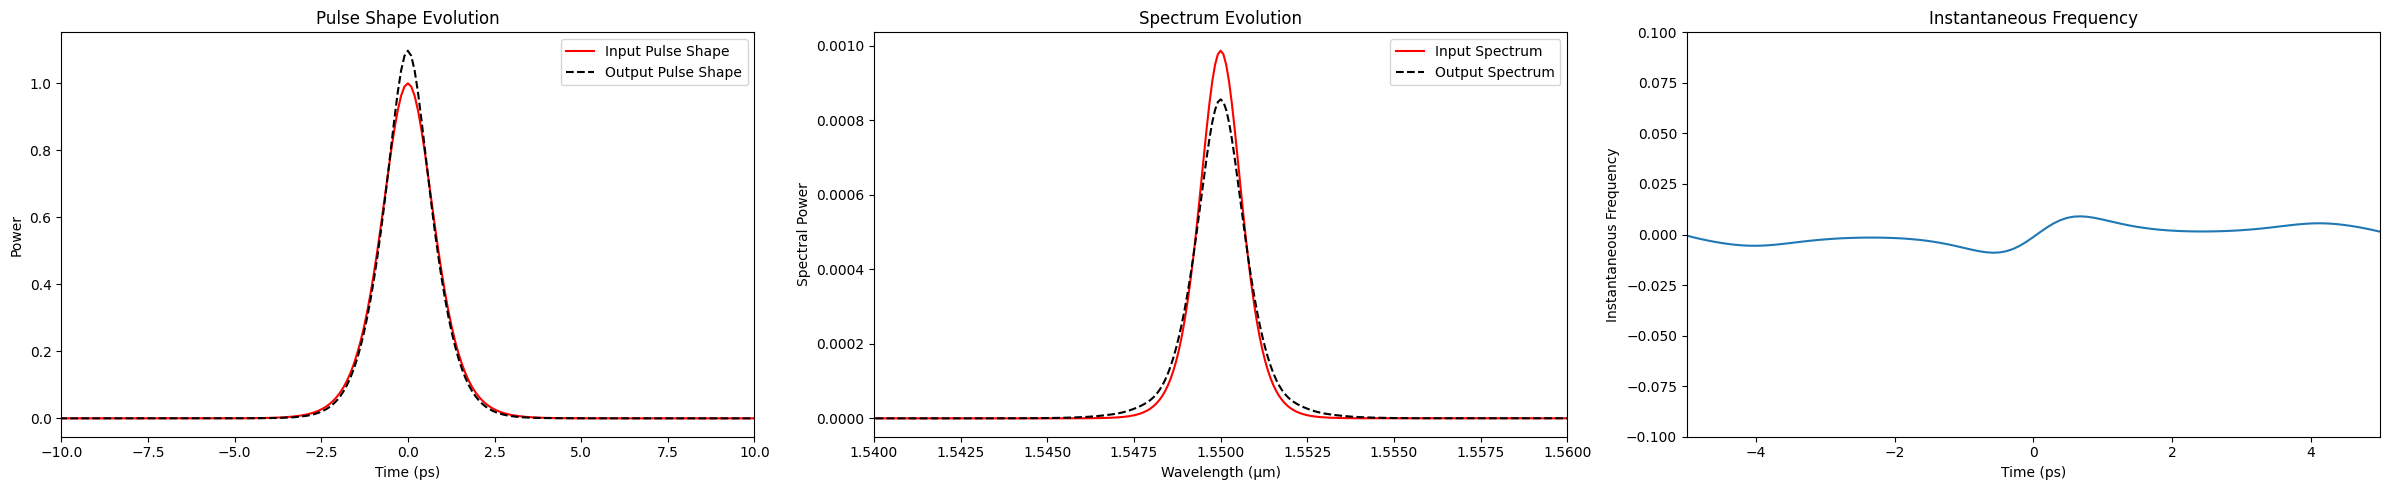

In [46]:
# Original plots (2D)
# Time domain plot
plt.figure(figsize=(24, 5))
plt.subplot(131)
plt.plot(t*1e12, abs(a0)**2, 'r', label='Input Pulse Shape')
plt.plot(t*1e12, abs(time_evolution[-1])**2, 'k--', label='Output Pulse Shape')
plt.legend()
plt.xlim([-10, 10])
plt.ylabel('Power')
plt.xlabel('Time (ps)')
plt.title('Pulse Shape Evolution')

# Frequency domain plot
plt.subplot(132)
wavelength_in = c/(f + c/1550e-9) * 1e6
plt.plot(wavelength_in, abs(A0)**2, 'r', label='Input Spectrum')
plt.plot(wavelength_in, abs(spectrum_evolution[-1])**2, 'k--', label='Output Spectrum')
plt.legend()
plt.xlim([1.54, 1.56])
plt.ylabel('Spectral Power')
plt.xlabel('Wavelength (μm)')
plt.title('Spectrum Evolution')

# Instantaneous frequency plot
plt.subplot(133)
phase = np.angle(time_evolution[-1])
inst_freq = -np.diff(phase)/(2*pi)
plt.plot(t[1:]*1e12, inst_freq)
plt.xlim([-5, 5])
plt.ylim([-0.1, 0.1])
plt.xlabel('Time (ps)')
plt.ylabel('Instantaneous Frequency')
plt.title('Instantaneous Frequency')

plt.tight_layout()
plt.show()

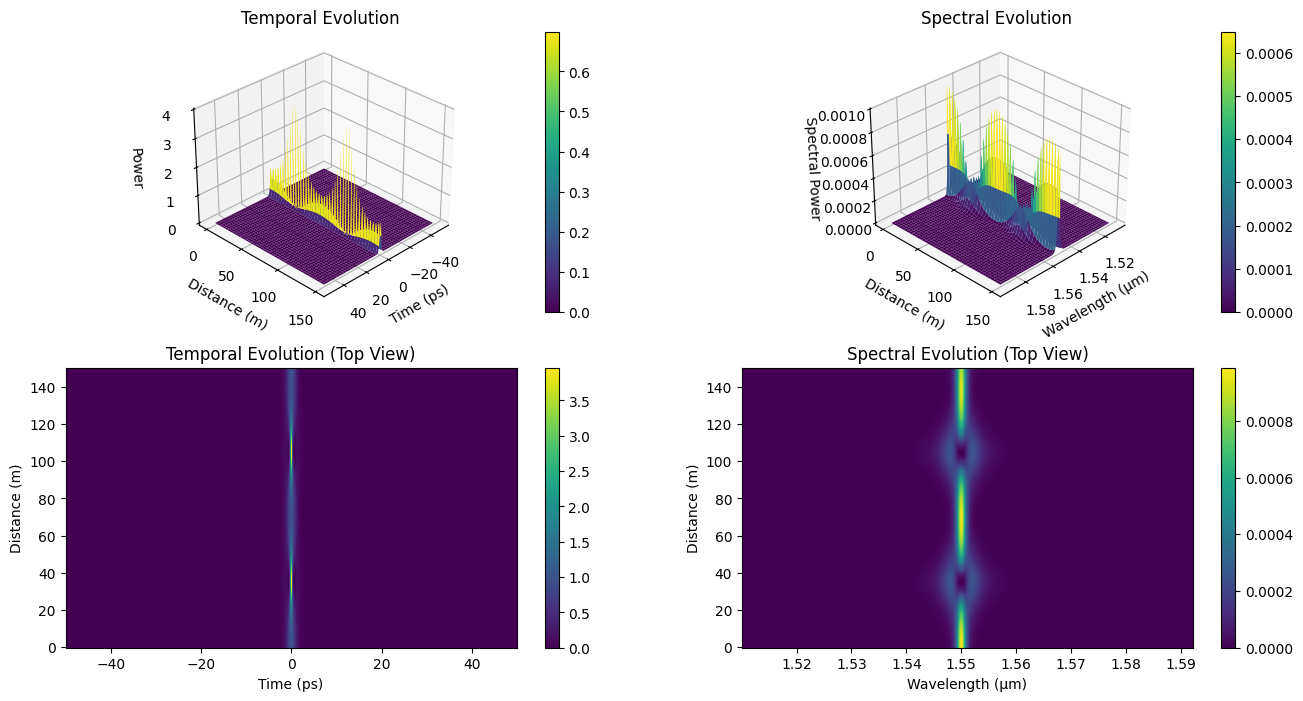

In [47]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(221, projection='3d')
T, Z = np.meshgrid(t*1e12, z_points)
intensity_t = np.abs(time_evolution)**2
surf1 = ax1.plot_surface(T, Z, intensity_t, cmap=cm.viridis, linewidth=0, antialiased=True)
plt.colorbar(surf1, ax=ax1, pad=0.15)
ax1.set_xlabel('Time (ps)')
ax1.set_ylabel('Distance (m)')
ax1.set_zlabel('Power')
ax1.view_init(elev=30, azim=45)
ax1.set_title('Temporal Evolution')

ax2 = fig.add_subplot(222, projection='3d')
wavelength = c/(f + c/1550e-9) * 1e6
W, Z = np.meshgrid(wavelength, z_points)
intensity_f = np.abs(spectrum_evolution)**2
surf2 = ax2.plot_surface(W, Z, intensity_f, cmap=cm.viridis, linewidth=0, antialiased=True)
plt.colorbar(surf2, ax=ax2, pad=0.15)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Distance (m)')
ax2.set_zlabel('Spectral Power')
ax2.view_init(elev=30, azim=45)
ax2.set_title('Spectral Evolution')

ax3 = fig.add_subplot(223)
im = ax3.pcolormesh(T, Z, intensity_t, cmap=cm.viridis, shading='auto')
plt.colorbar(im, ax=ax3)
ax3.set_xlabel('Time (ps)')
ax3.set_ylabel('Distance (m)')
ax3.set_title('Temporal Evolution (Top View)')

ax4 = fig.add_subplot(224)
im = ax4.pcolormesh(W, Z, intensity_f, cmap=cm.viridis, shading='auto')
plt.colorbar(im, ax=ax4)
ax4.set_xlabel('Wavelength (μm)')
ax4.set_ylabel('Distance (m)')
ax4.set_title('Spectral Evolution (Top View)')
plt.show()